In [54]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
import os


In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Using cpu device


The number of training samples in the dataset: 112800
The number of testing samples in the dataset: 18800


C:\Users\godwi\AppData\Local\Temp\ipykernel_14924\2867807527.py:32: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  plt.imshow(img.T.squeeze(), cmap="gray")


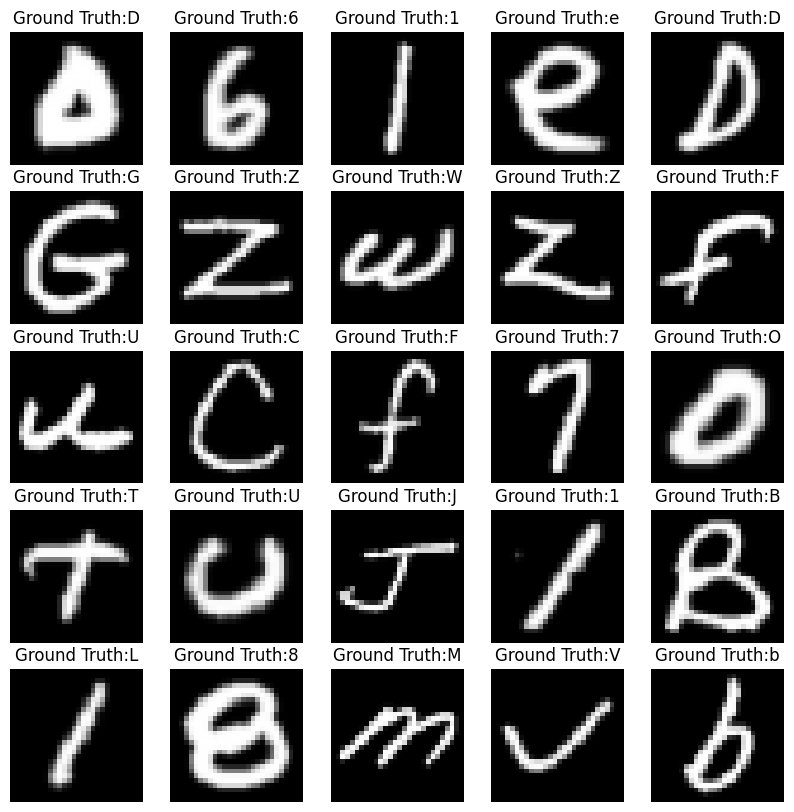

In [8]:
train_set = torchvision.datasets.EMNIST(root = "./data/EMNIST", split = "balanced", download = True,
                                        train = True, transform = transforms.Compose([transforms.ToTensor()]))

test_set = torchvision.datasets.EMNIST(root = "./data/EMNIST", split = "balanced", download = True,
                                       train = False, transform = transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True)

print("The number of training samples in the dataset:", len(train_set))
print("The number of testing samples in the dataset:", len(test_set))


def mapping(label):
  mapping = np.loadtxt("./emnist-balanced-mapping.txt", dtype = int)
  itemindex = mapping.T[0].tolist().index(label)
  return mapping.T[1][itemindex]


torch.manual_seed(0)

figure = plt.figure(figsize=(10,10))
cols, rows = 5, 5
for i in range (1, cols*rows +1):
  sample_idx = torch.randint(len(train_set), size=(1,)).item()
  img, label = train_set[sample_idx]
  figure.add_subplot(rows, cols, i)

  plt.title("Ground Truth:{}".format(chr(mapping(label))))
  plt.axis("off")
  plt.imshow(img.T.squeeze(), cmap="gray")

plt.show()

In [15]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        # Replaces pow(2.0) with abs() for L1 regularization
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct

def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    y_pred = []
    y_actu = []
    with torch.no_grad():
      for images, labels in dataloader:

          images,labels = images.to(device),labels.to(device)
          output = model(images)
          loss=loss_fn(output,labels)
          valid_loss+=loss.item()*images.size(0)
          scores, predictions = torch.max(output.data,1)
          val_correct+=(predictions == labels).sum().item()

          y_pred.extend(torch.flatten(predictions).tolist())
          y_actu.extend(labels.tolist())

      y_predicted = pd.Series(y_pred, name="Actual")
      y_actual = pd.Series(y_actu, name="Predicted")
      cm = pd.crosstab(y_actual, y_predicted)

    return valid_loss,val_correct,cm, y_pred, y_actu

In [31]:
class NeuralNetwork(nn.Module):
  def __init__(self, activation_function):
    super(NeuralNetwork, self).__init__()
    self.activation_function = activation_function
    self.flatten = nn.Flatten()
    self.linear_actfun_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        self.activation_function,
        #nn.Dropout(0.2),
        nn.BatchNorm1d(512),
        nn.Linear(512, 512),
        self.activation_function,
        #nn.Dropout(0.2),
        nn.BatchNorm1d(512),
        nn.Linear(512, 512),
        self.activation_function,
        #nn.Dropout(0.2),
        nn.BatchNorm1d(512),
        nn.Linear(512, 47),
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_actfun_stack(x)
    return logits

# Change activation function
model = NeuralNetwork(nn.LeakyReLU()).to(device)

print(model)

NeuralNetwork(
  (activation_function): LeakyReLU(negative_slope=0.01)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_actfun_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=512, out_features=47, bias=True)
  )
)


In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
criterion = nn.CrossEntropyLoss()

#train_loader
dataset = ConcatDataset([train_set, test_set])

num_epochs=5
batch_size=128

In [33]:
import time
start_time = time.time()

history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

#
train_set = torchvision.datasets.EMNIST(root = "./data/EMNIST", split = "balanced", download = True,
                                        train = True, transform = transforms.Compose([transforms.ToTensor()]))

test_set = torchvision.datasets.EMNIST(root = "./data/EMNIST", split = "balanced", download = True,
                                       train = False, transform = transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True)
#

model = NeuralNetwork(nn.LeakyReLU())
model.to(device)
optimizer = optim.ASGD(model.parameters(), lr=0.1)

for epoch in range(num_epochs):
    train_loss, train_correct = train_epoch(model,device,train_loader,criterion,optimizer)
    test_loss, test_correct, confusion_matrix, y_pred, y_actu = valid_epoch(model,device,test_loader,criterion)

    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler) * 100
    test_loss = test_loss / len(test_loader.sampler)
    test_acc = test_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                          num_epochs,
                                                                                                          train_loss,
                                                                                                          test_loss,
                                                                                                          train_acc,
                                                                                                          test_acc))
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)   


print("--- runtime: %s seconds ---" % (time.time() - start_time))



Epoch:1/5 AVG Training Loss:2.484 AVG Test Loss:0.565 AVG Training Acc 76.35 % AVG Test Acc 81.23 %
Epoch:2/5 AVG Training Loss:1.682 AVG Test Loss:0.500 AVG Training Acc 83.07 % AVG Test Acc 83.15 %
Epoch:3/5 AVG Training Loss:1.285 AVG Test Loss:0.490 AVG Training Acc 84.63 % AVG Test Acc 83.93 %
Epoch:4/5 AVG Training Loss:1.051 AVG Test Loss:0.485 AVG Training Acc 85.46 % AVG Test Acc 83.43 %
Epoch:5/5 AVG Training Loss:0.910 AVG Test Loss:0.466 AVG Training Acc 85.92 % AVG Test Acc 84.47 %
--- runtime: 204.98845076560974 seconds ---


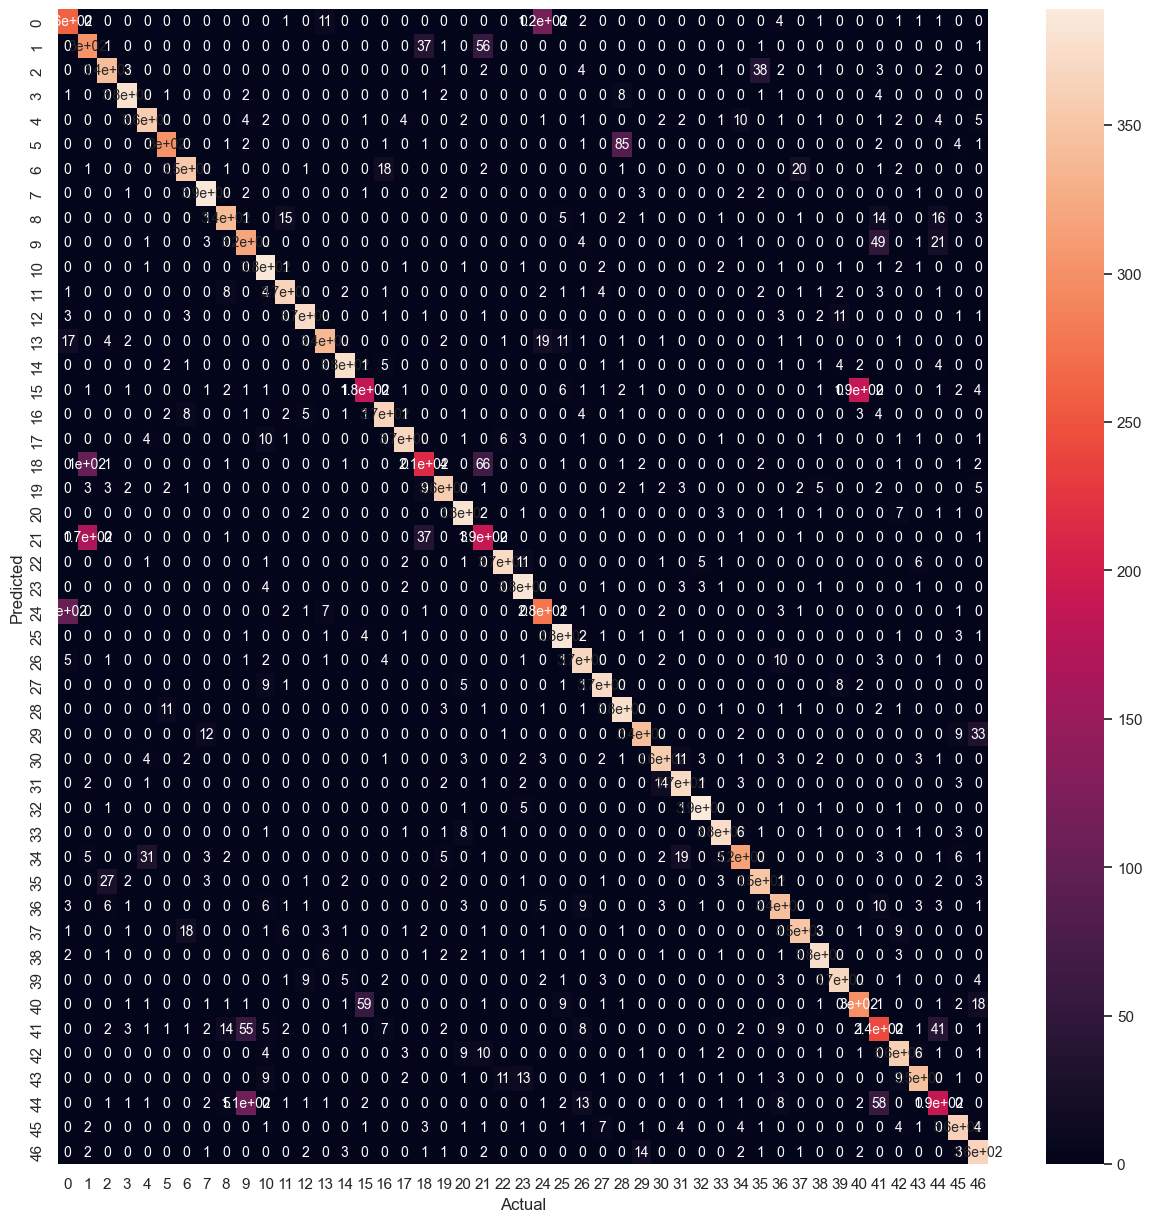

In [34]:
sns.set(font_scale=1) # for label size
plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 10}) # font size

plt.show()

In [35]:

avg_train_loss = np.mean(history['train_loss'])
avg_test_loss = np.mean(history['test_loss'])
avg_train_acc = np.mean(history['train_acc'])
avg_test_acc = np.mean(history['test_acc'])

print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}".format(avg_train_loss,avg_test_loss,avg_train_acc,avg_test_acc))  

Average Training Loss: 1.4823 	 Average Test Loss: 0.5012 	 Average Training Acc: 83.084 	 Average Test Acc: 83.241


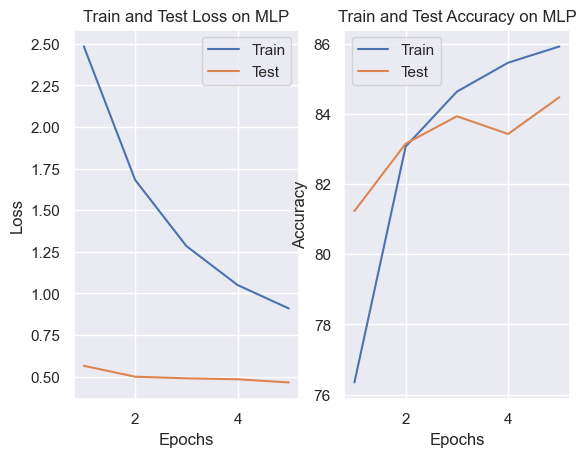

In [36]:
figure, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(range(1, num_epochs+1), history['train_loss'], label = "Train")
ax1.plot(range(1, num_epochs+1), history['test_loss'], label = "Test")
ax1.set_title("Train and Test Loss on MLP")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()


ax2.plot(range(1, num_epochs+1), history['train_acc'], label = "Train")
ax2.plot(range(1, num_epochs+1), history['test_acc'], label = "Test")
ax2.set_title("Train and Test Accuracy on MLP")
ax2.set(xlabel = "Epochs", ylabel = "Accuracy")
ax2.legend()

Prediction: 16974
Prediction: 4557
Prediction: 4231
Prediction: 1366
Prediction: 18132
Prediction: 8183


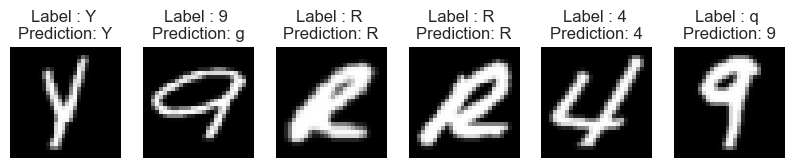

In [37]:

figure = plt.figure(figsize=(10,10))
cols, rows = 6, 1
for i in range(1, cols*rows+1):
  sample_idx = torch.randint(len(test_set), size=(1,)).item()
  print("Prediction: {}".format(sample_idx))
  img, label = test_set[sample_idx]
  img = img.to(device)
  #print(img.shape)
  pred = model(img.reshape(-1,1,28,28)).argmax()
  figure.add_subplot(rows, cols, i)
  #plt.title("Label "+ str(label))
  plt.title("Label : {} \nPrediction: {}".format(chr(mapping(label)), chr(mapping(pred))))
  plt.axis("off")
  plt.imshow(img.T.cpu().squeeze(), cmap="gray")
plt.show()

In [42]:
cm = confusion_matrix(y_actu, y_pred)
recall = np.diag(cm)/np.sum(cm, axis=1)
precision = np.diag(cm)/np.sum(cm, axis=0)
mean_recall = np.mean(recall)
mean_precision = np.mean(precision)

print('Accuracy:', accuracy_score(y_actu, y_pred))
print('Recall:', mean_recall)
print('Precision:', mean_precision)
print('F1 score:', 2*mean_recall*mean_precision/(mean_recall+mean_precision))



Accuracy: 0.8447340425531915
Recall: 0.8447340425531915
Precision: 0.8485064061843643
F1 score: 0.8466160221518463


In [43]:
class CNN(nn.Module):
  def __init__(self, activation_function):
    super(CNN, self).__init__()
    self.activation_function = activation_function

    self.bn1 = nn.BatchNorm2d(10)
    self.bn2 = nn.BatchNorm2d(20)
    self.bn3 = nn.BatchNorm1d(500)

    self.conv1 = nn.Conv2d(1,10,5)
    self.conv2 = nn.Conv2d(10,20,3)

    self.fc1 = nn.Linear(20*10*10, 500)
    self.fc2 = nn.Linear(500, 47)

    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    input_size = x.size(0)

    x = self.conv1(x)
    x = self.activation_function(x)
    x = F.max_pool2d(x,2,2)
    x = self.bn1(x)
    #x = self.dropout(x)

    x = self.conv2(x)
    x = self.activation_function(x)
    x = self.bn2(x)
    #x = self.dropout(x)

    x = x.view(input_size, -1)

    x = self.fc1(x)
    x = self.activation_function(x)
    x = self.bn3(x)
    #x = self.dropout(x)

    x = self.fc2(x)
    return F.log_softmax(x)

In [44]:
import time
start_time = time.time()

history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

#
train_set = torchvision.datasets.EMNIST(root = "./data/EMNIST", split = "balanced", download = True,
                                        train = True, transform = transforms.Compose([transforms.ToTensor()]))

test_set = torchvision.datasets.EMNIST(root = "./data/EMNIST", split = "balanced", download = True,
                                       train = False, transform = transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True)
#

model = CNN(F.leaky_relu)
model.to(device)
optimizer = optim.ASGD(model.parameters(), lr=0.1)

for epoch in range(num_epochs):
    train_loss, train_correct = train_epoch(model,device,train_loader,criterion,optimizer)
    test_loss, test_correct, confusion_matrix, y_pred, y_actu = valid_epoch(model,device,test_loader,criterion)

    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler) * 100
    test_loss = test_loss / len(test_loader.sampler)
    test_acc = test_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                          num_epochs,
                                                                                                          train_loss,
                                                                                                          test_loss,
                                                                                                          train_acc,
                                                                                                          test_acc))
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)   


print("--- runtime: %s seconds ---" % (time.time() - start_time))


C:\Users\godwi\AppData\Local\Temp\ipykernel_14924\475854436.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch:1/5 AVG Training Loss:1.166 AVG Test Loss:0.411 AVG Training Acc 82.68 % AVG Test Acc 85.94 %


C:\Users\godwi\AppData\Local\Temp\ipykernel_14924\475854436.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch:2/5 AVG Training Loss:0.824 AVG Test Loss:0.401 AVG Training Acc 87.60 % AVG Test Acc 86.21 %


C:\Users\godwi\AppData\Local\Temp\ipykernel_14924\475854436.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch:3/5 AVG Training Loss:0.690 AVG Test Loss:0.368 AVG Training Acc 88.67 % AVG Test Acc 87.62 %


C:\Users\godwi\AppData\Local\Temp\ipykernel_14924\475854436.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch:4/5 AVG Training Loss:0.620 AVG Test Loss:0.363 AVG Training Acc 89.18 % AVG Test Acc 87.53 %


C:\Users\godwi\AppData\Local\Temp\ipykernel_14924\475854436.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch:5/5 AVG Training Loss:0.581 AVG Test Loss:0.382 AVG Training Acc 89.56 % AVG Test Acc 87.37 %
--- runtime: 623.7560727596283 seconds ---


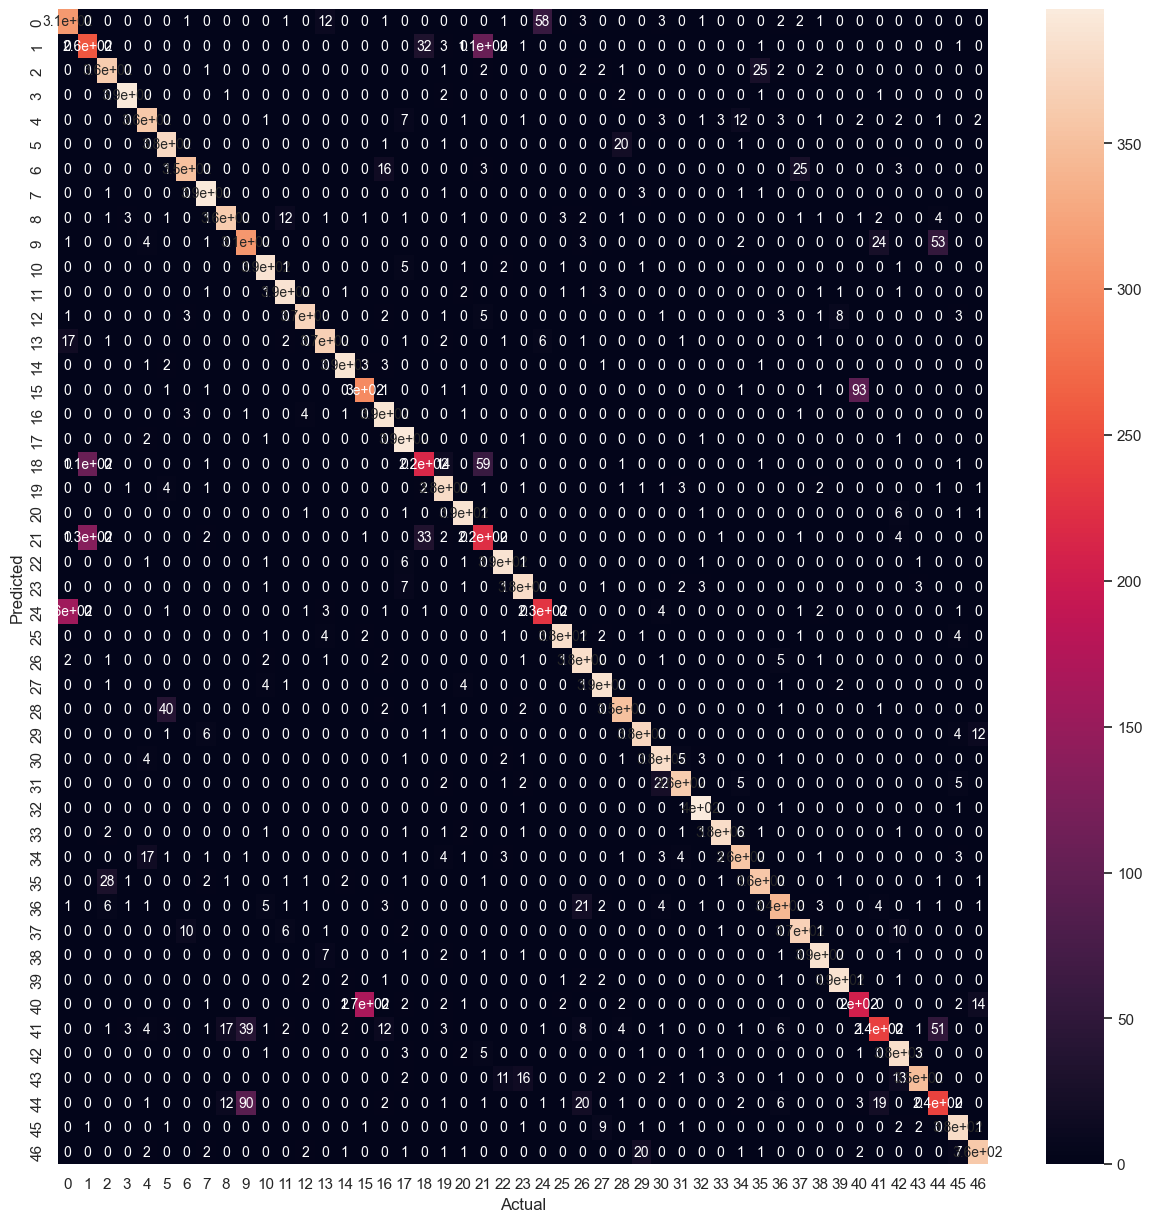

In [45]:
sns.set(font_scale=1) # for label size
plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 10}) # font size

plt.show()

In [46]:
avg_train_loss = np.mean(history['train_loss'])
avg_test_loss = np.mean(history['test_loss'])
avg_train_acc = np.mean(history['train_acc'])
avg_test_acc = np.mean(history['test_acc'])

print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}".format(avg_train_loss,avg_test_loss,avg_train_acc,avg_test_acc))  


Average Training Loss: 0.7761 	 Average Test Loss: 0.3852 	 Average Training Acc: 87.535 	 Average Test Acc: 86.935


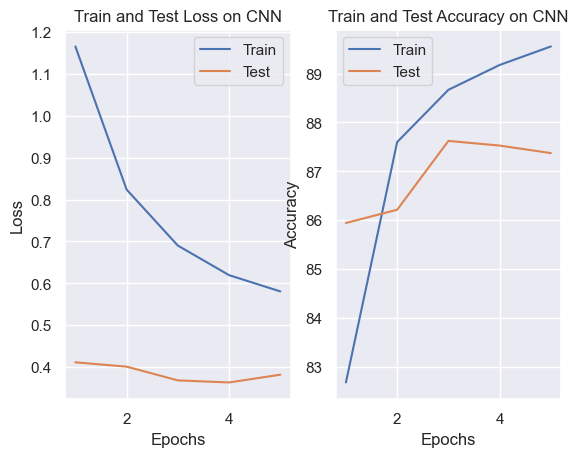

In [47]:
figure, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(range(1, num_epochs+1), history['train_loss'], label = "Train")
ax1.plot(range(1, num_epochs+1), history['test_loss'], label = "Test")
ax1.set_title("Train and Test Loss on CNN")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()


ax2.plot(range(1, num_epochs+1), history['train_acc'], label = "Train")
ax2.plot(range(1, num_epochs+1), history['test_acc'], label = "Test")
ax2.set_title("Train and Test Accuracy on CNN")
ax2.set(xlabel = "Epochs", ylabel = "Accuracy")
ax2.legend()


Prediction: 13062
Prediction: 410
Prediction: 678


C:\Users\godwi\AppData\Local\Temp\ipykernel_14924\475854436.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Prediction: 12204
Prediction: 12971
Prediction: 15685


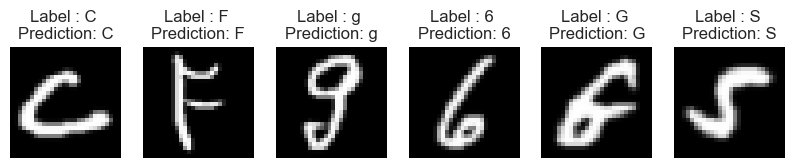

In [48]:
figure = plt.figure(figsize=(10,10))
cols, rows = 6, 1
for i in range(1, cols*rows+1):
  sample_idx = torch.randint(len(test_set), size=(1,)).item()
  print("Prediction: {}".format(sample_idx))
  img, label = test_set[sample_idx]
  img = img.to(device)
  #print(img.shape)
  pred = model(img.reshape(-1,1,28,28)).argmax()
  figure.add_subplot(rows, cols, i)
  #plt.title("Label "+ str(label))
  plt.title("Label : {} \nPrediction: {}".format(chr(mapping(label)), chr(mapping(pred))))
  plt.axis("off")
  plt.imshow(img.T.cpu().squeeze(), cmap="gray")
plt.show()

In [55]:
cm = confusion_matrix(y_actu, y_pred)
recall = np.diag(cm)/np.sum(cm, axis=1)
precision = np.diag(cm)/np.sum(cm, axis=0)
mean_recall = np.mean(recall)
mean_precision = np.mean(precision)

print('Accuracy:', accuracy_score(y_actu, y_pred))
print('Recall:', mean_recall)
print('Precision:', mean_precision)
print('F1 score:', 2*mean_recall*mean_precision/(mean_recall+mean_precision))

Accuracy: 0.8737234042553191
Recall: 0.8737234042553196
Precision: 0.8753887605488888
F1 score: 0.8745552895965769
